# Polars

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [2]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

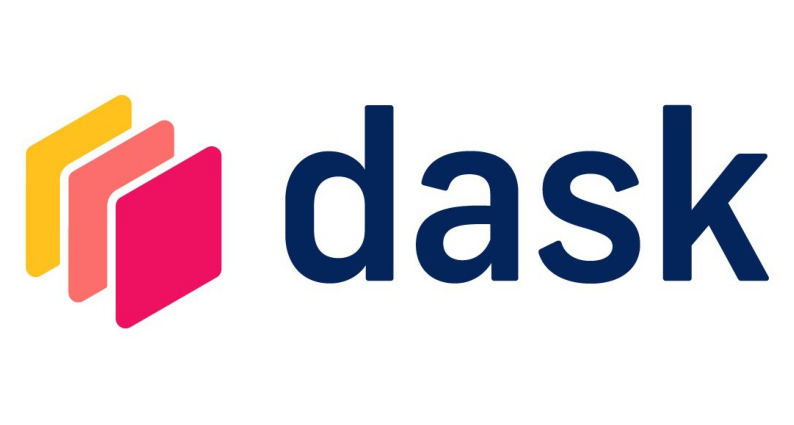

In [3]:
display_img('Dask.jpeg', 10, 10)

Python packages like numpy, pandas, sklearn, seaborn etc. makes the data manipulation and ML tasks very convenient. For most data analysis tasks, the python pandas package is good enough. You can do all sorts of data manipulation and is compatible for building ML models.

But, as your data gets bigger, bigger than what you can fit in the RAM, pandas won’t be sufficient.

This is a very common problem.

You may use Spark or Hadoop to solve this. But, these are not python environments. This stops you from using numpy, sklearn, pandas, tensorflow, and all the commonly used Python libraries for ML.

Is there a solution for this?

Yes! This is where Dask comes in.

### What is Dask?

Dask is a open-source library that provides advanced parallelization for analytics, especially when you are working with large data.

It is built to help you improve code performance and scale-up without having to re-write your entire code. The good thing is, you can use all your favorite python libraries as Dask is built in coordination with numpy, scikit-learn, scikit-image, pandas, xgboost, RAPIDS and others.

In [4]:
import time

In [5]:
start = time.time()

# 1. How to implement Parallel Processing with Dask

### i. Regular code

In [6]:
from time import sleep

def apply_discount(x):
  sleep(1)
  x = x - 0.2*x
  return x

def get_total(a,b):
  sleep(1)
  return a + b

def get_total_price(x,y):
  sleep(1)
  a = apply_discount(x)
  b = apply_discount(y)
  get_total(a, b)

In [7]:
%%time

x = apply_discount(100)
y = apply_discount(200)
z = get_total_price(x,y)

CPU times: user 793 µs, sys: 693 µs, total: 1.49 ms
Wall time: 6.03 s


### ii. Code with Dask (Delayed)

**What does dask.delayed do?**

It creates a delayed object, that keeps track of all the functions to call and the arguments to pass to it. Basically, it builds a task graph that explains the entire computation. It helps to spot opportunities for parallel execution.

So, the z object created in the above code is a delayed object OR “lazy object” which has all information for executing the logic. You can see the optimal task graph created by dask by calling the visualize() function.

In [8]:
import dask
from dask import delayed

**a. Creating Arquitechture**

In [9]:
%%time

x = delayed(apply_discount)(100)
y = delayed(apply_discount)(200)
z = delayed(get_total_price)(x, y)

CPU times: user 467 µs, sys: 307 µs, total: 774 µs
Wall time: 520 µs


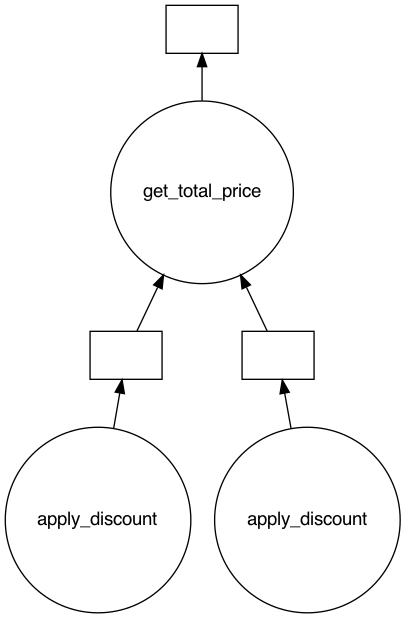

In [10]:
z.visualize()

**b. Compute**

We can now compute this lazy result to execute the graph in parallel.

In [11]:
%%time

z.compute()

CPU times: user 90.3 ms, sys: 19.5 ms, total: 110 ms
Wall time: 5.16 s


Though it’s just 1 sec, the total time taken has reduced. This is the basic concept of parallel computing. Dask makes it very convenient.

# 2. Parallelizing a for loop

In [12]:
import numpy as np

In [13]:
def square(x):
    return x*x

def double(x):
    return x*2

def add(x, y):
    return x + y

def sum_2(l):
    return np.array(l).sum()

In [14]:
N = 8

### i. Creating arquitechture

In [15]:
%%time

output = []

for i in range(N):

    a = delayed(square)(i)
    b = delayed(double)(i)
    c = delayed(add)(a, b)
    output.append(c)

total = dask.delayed(sum_2)(output)

CPU times: user 2.5 ms, sys: 1.26 ms, total: 3.76 ms
Wall time: 2.85 ms


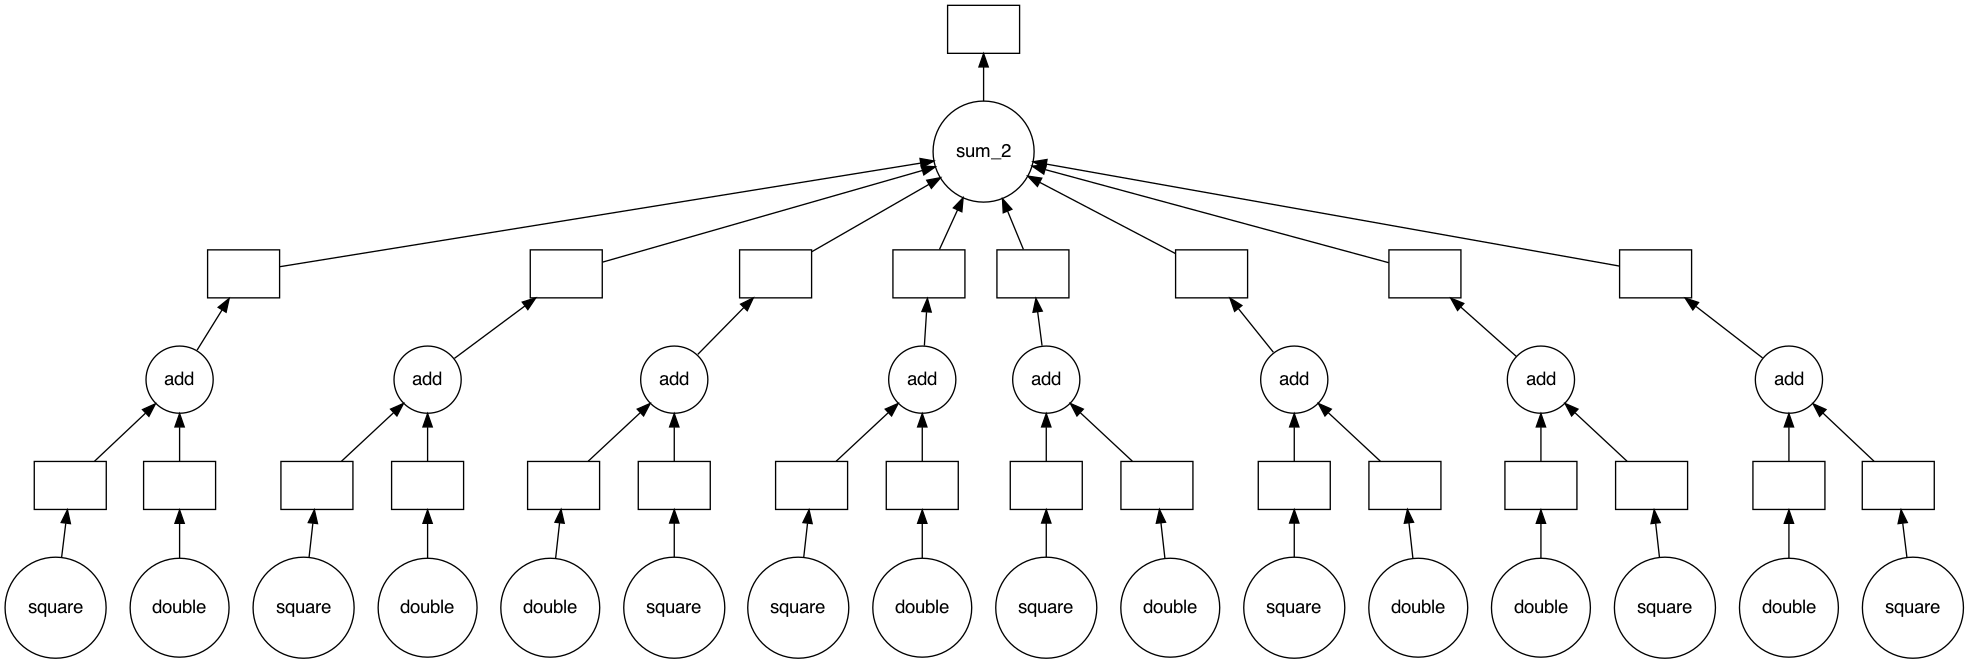

In [16]:
total.visualize()

### ii. Compute

In [17]:
%%time

total.compute()

CPU times: user 2.13 ms, sys: 1.72 ms, total: 3.85 ms
Wall time: 3.18 ms


196

### iii. Decorators

In [18]:
@delayed
def square(x):
    return x*x

@delayed
def double(x):
    return x*2

@delayed
def add(x, y):
    return x + y

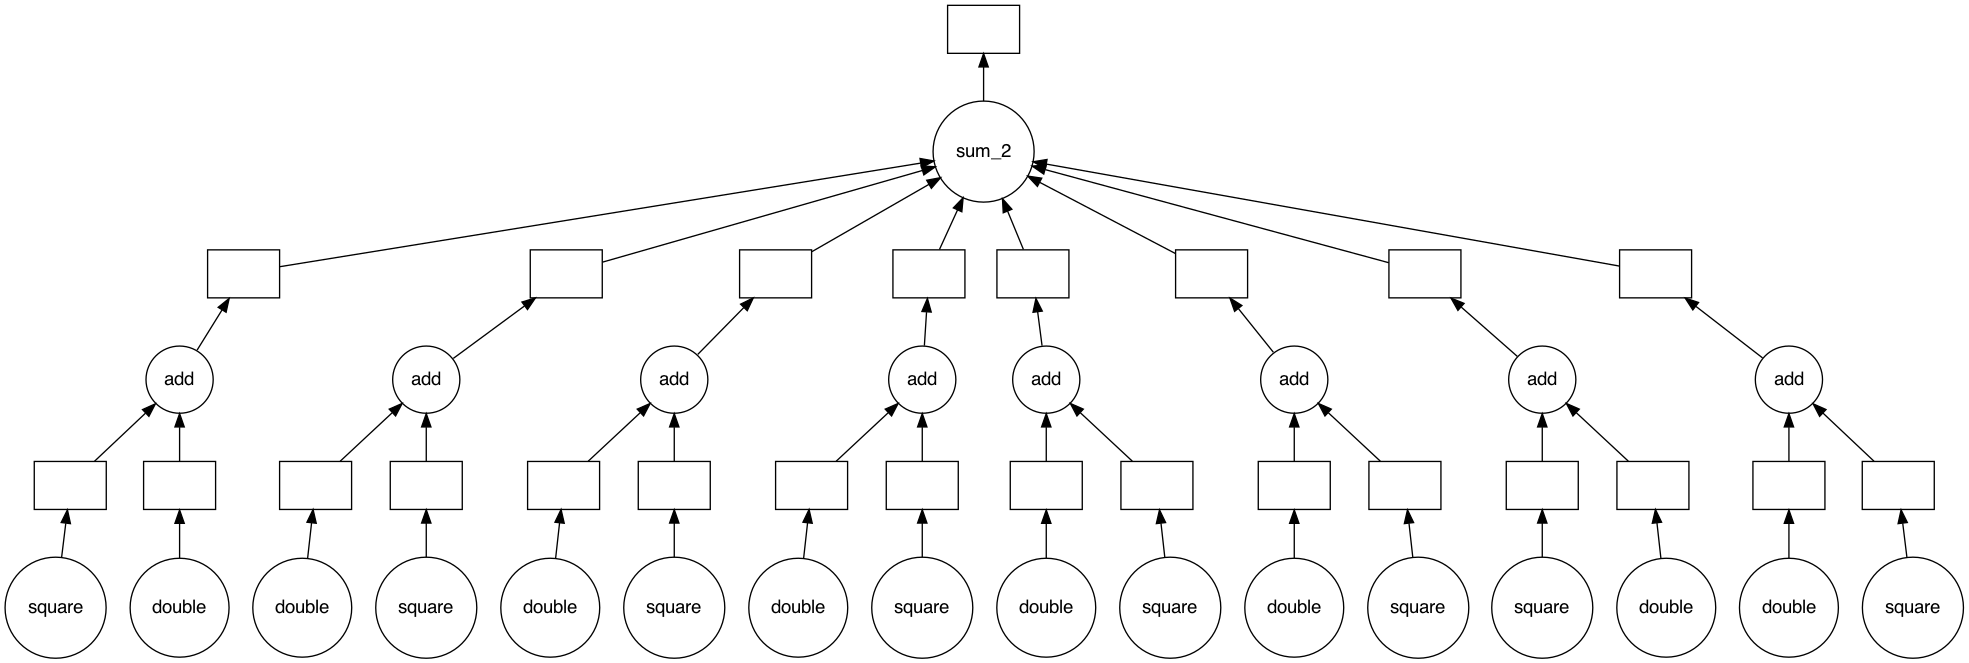

In [19]:
output = []

for i in range(N):
    a = square(i)
    b = double(i)
    c = add(a, b)
    output.append(c)

total = dask.delayed(sum_2)(output)
total.visualize()

# 3. Dask DataFrames

You saw how Dask helps to overcome the problem of long execution and training time. Another important problem we discussed was the larger-than-memory datasets.

The commonly used library for working with datasets is Pandas. But, many real-life ML problems have datasets that are larger than your RAM memory!

A Dask DataFrame is a large parallel DataFrame composed of many smaller Pandas DataFrames, split along the index. 

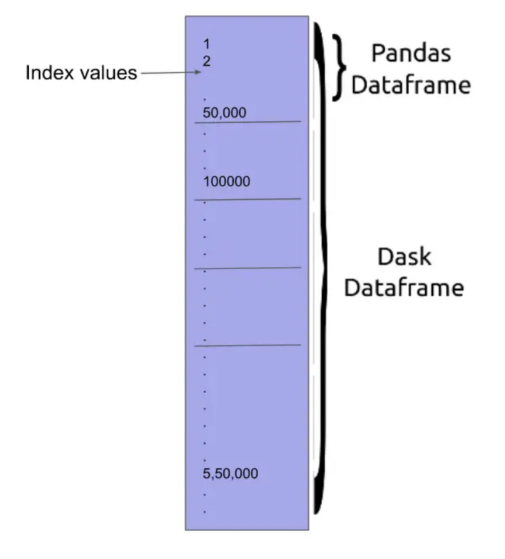

In [20]:
display_img('Dask_DF.png', 7, 7)

In [21]:
import dask
import dask.dataframe as dd

In [22]:
data_frame = dask.datasets.timeseries()

In [23]:
data_frame

,name,id,x,y
npartitions=30,,,,
2000-01-01,object,int64,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


You can see that only the structure is there, no data has been printed. It’s because Dask Dataframes are lazy and do not perform operations unless necessary. You can use the head() method to visualize data.

In [24]:
data_frame.head()

,name,id,x,y
timestamp,,,,
2000-01-01 00:00:00,Xavier,942,-0.548491,0.328373
2000-01-01 00:00:01,Laura,994,-0.879052,-0.601413
2000-01-01 00:00:02,Edith,997,-0.790655,0.002439
2000-01-01 00:00:03,Oliver,1000,0.752608,0.709764
2000-01-01 00:00:04,Kevin,945,0.726378,-0.774638


Now, let’s just perform a few basic operations which are expected from pandas using dask dataframe now. One of the most standard operations is to groupby().

In [25]:
df = data_frame.groupby('name').y.std()

In [26]:
df

Dask Series Structure:
npartitions=1
    float64
        ...
Name: y, dtype: float64
Dask Name: sqrt, 6 graph layers

### i. Compute

If you want the results then you can call compute() function as shown below.

In [27]:
df.compute()

name
Alice       0.576815
Bob         0.577983
Charlie     0.577626
Dan         0.576619
Edith       0.575828
Frank       0.576899
George      0.577176
Hannah      0.577513
Ingrid      0.578191
Jerry       0.575891
Kevin       0.577480
Laura       0.576993
Michael     0.577988
Norbert     0.577135
Oliver      0.578007
Patricia    0.577598
Quinn       0.577798
Ray         0.578584
Sarah       0.577827
Tim         0.578755
Ursula      0.576814
Victor      0.577534
Wendy       0.577532
Xavier      0.579835
Yvonne      0.578489
Zelda       0.576897
Name: y, dtype: float64

The compute() function turns a lazy Dask collection into its in-memory equivalent (in this case pandas dataframe). You can verify this with type() function as shown below.

In [28]:
result_df = df.compute()

In [29]:
type(result_df)

pandas.core.series.Series

### ii. Persist

This function turns a lazy Dask collection into a Dask collection with the same metadata. The difference is earlier the results were not computed, it just had the information. Now, the results are fully computed or actively computing in the background.

This function is particularly useful when using distributed systems, because the results will be kept in distributed memory, rather than returned to the local process as with compute.

In [30]:
df = df.persist()

In [31]:
df

Dask Series Structure:
npartitions=1
    float64
        ...
Name: y, dtype: float64
Dask Name: sqrt, 1 graph layer

In [32]:
df.loc['2000-01-05']

Dask Series Structure:
npartitions=1
    float64
        ...
Name: y, dtype: float64
Dask Name: try_loc, 2 graph layers

In [33]:
df.loc['2000-01-05'].compute()

Series([], Name: y, dtype: float64)

# 4. Dask Bags

In many cases, the raw input has a lot of messy data that needs processing. The messy data is often processed and represented as a sequence of arbitrary inputs. Usually, they are processed in form of lists, dicts, sets, etc. A common problem is when they take up a lot of storage and iterating through them takes time.

Is there a way to optimize data processing at raw-level?

Yes! The answer is Dask Bags.

### i. What are Dask Bags?

Dask.bag is a high-level Dask collection used as an alternative for the regular python lists, etc. The main difference is Dask Bags are lazy and distributed.

Dask Bag implements operations like map, filter, fold, and groupby on collections of generic Python objects. We prefer Dask bags because it provides the best optimization.

### ii. What are the advantages of using Dask bags ?

* It lets you process large volumes of data in a small space, just like toolz.

* Dask bags follow parallel computing. The data is split up, allowing multiple cores or machines to execute in parallel.

* The execution part usually consists of running many iterations. In these iterations, data is processed lazily in the case of Dask bag. It allows for smooth execution.

### iii. How create Dask Bags?

Dask provides you different ways to create a bag from various python objects. Let’s look at each method with an example.

### Method 1:

In [34]:
bag_1 = dask.bag.from_sequence(['Haritha', 'keerthi', 'Newton','Swetha','Sinduja'], partition_size = 2)

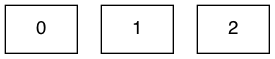

In [35]:
bag_1.visualize()

In [36]:
bag_1.count().compute()

5

### Method 2:

In [37]:
a = dask.bag.from_url('http://raw.githubusercontent.com/dask/dask/master/README.rst',) 

In [38]:
a.npartitions

1

In [39]:
a.count().compute()

30

In [40]:
b = dask.bag.from_url(['http://github.com', 'http://google.com']) 
b.npartitions

2

In [41]:
b.count().compute()

2511

# 5. Convert Dask Bags from others forms

### i. Dataframe

In [42]:
df_bag_1 = bag_1.to_dataframe()

In [43]:
df_bag_1.compute()

,0
0,Haritha
1,keerthi
0,Newton
1,Swetha
0,Sinduja


In [44]:
df_a = a.to_dataframe()

In [45]:
df_a.compute()

,0
0,b'Dask\n'
1,b'====\n'
2,b'\n'
3,b'|Build Status| |Coverage| |Doc Status| |Disc...
4,b'\n'
5,b'Dask is a flexible parallel computing librar...
6,b'documentation_ for more information.\n'
7,b'\n'
8,b'\n'
9,b'LICENSE\n'


### ii. Text Files

In [46]:
bag_1.to_textfiles('bag_1.txt')

['/Users/albertovaldes/Desktop/Beto_Sessions/General_Topics/36.Dask/bag_1.txt/0.part',
 '/Users/albertovaldes/Desktop/Beto_Sessions/General_Topics/36.Dask/bag_1.txt/1.part',
 '/Users/albertovaldes/Desktop/Beto_Sessions/General_Topics/36.Dask/bag_1.txt/2.part']

In [47]:
a.to_textfiles('a.txt')

['/Users/albertovaldes/Desktop/Beto_Sessions/General_Topics/36.Dask/a.txt/0.part']

# 6. Distributed Computing

In [48]:
from dask.distributed import Client
import pandas as pd
import time

In [49]:
client = Client(processes = False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.100.7:8787/status,
Dashboard: http://192.168.100.7:8787/status,Workers: 1
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: False
Comm: inproc://192.168.100.7/3718/1,Workers: 1
Dashboard: http://192.168.100.7:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: inproc://192.168.100.7/3718/4,Total threads: 8
Dashboard: http://192.168.100.7:50068/status,Memory: 8.00 GiB
Nanny: None,


In [50]:
df = pd.read_parquet('train.parquet')

In [51]:
df.head()

,user,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,num_7,num_8,num_9,num_10,num_11,num_12,num_13,num_14,num_15
0,37460,2,60,8,73,17,61,0.119154,0.792590,0.691714,0.413575,0.568960,0.724723,0.667784,0.621327,0.366504
1,6199,1,30,14,31,65,49,0.871286,0.864431,0.406232,0.685368,0.425132,0.184816,0.307660,0.497363,0.740807
2,67094,2,17,7,18,8,29,0.249553,0.950156,0.081369,0.563896,0.451576,0.778270,0.694566,0.807619,0.916968
3,97776,3,60,16,28,32,43,0.545136,0.463736,0.377657,0.728032,0.537577,0.943349,0.194909,0.684796,0.422892
4,18048,2,42,22,49,53,67,0.606616,0.757299,0.910864,0.187922,0.935874,0.810835,0.152005,0.035744,0.941222


In [52]:
cols_df = [f'cat_{i}' for i in range(1, 6 + 1)] + [f'num_{i}' for i in range(7, 15 + 1)] 

In [53]:
def mean_column(df, name_column):
    return df[name_column].mean()

In [54]:
%%time

for c_df in cols_df:
    print('Column:', c_df)
    print('Mean:', mean_column(df, c_df))
    print('-'*90)

Column: cat_1
Mean: 2.4999978
------------------------------------------------------------------------------------------
Column: cat_2
Mean: 32.5031245
------------------------------------------------------------------------------------------
Column: cat_3
Mean: 16.001439566666665
------------------------------------------------------------------------------------------
Column: cat_4
Mean: 38.99779993333333
------------------------------------------------------------------------------------------
Column: cat_5
Mean: 36.0007235
------------------------------------------------------------------------------------------
Column: cat_6
Mean: 34.00185893333333
------------------------------------------------------------------------------------------
Column: num_7
Mean: 0.49998460468705763
------------------------------------------------------------------------------------------
Column: num_8
Mean: 0.4999865543607455
-----------------------------------------------------------------------------

To create a future, call the client.scatter() function. What will this function do?

Basically, it moves data from the local client process into the workers of the distributed scheduler.

Here instead of simply calling the function, we will use client.submit() function. The client.submit() function is responsible for submitting a function application to the scheduler. To this function, you can pass the function defined, the future and other parameters.

The process is one. But, how to collect or gather the results?

We have client.gather() function for that. This function gathers futures from the distributed memory. It accepts a future, nested container of futures. The return type will match the input type. In the below example, we have passed the futures as input to this function.

In [55]:
# Scatter the dataframe beforehand
df_future = client.scatter(df)

In [56]:
%%time
# Use Dask client to parallelize the workload.

# Create a futures array to store the futures returned by Dask
futures = []

for c_df in cols_df:
    # Submit tasks to the dask client in parallel
    future = client.submit(mean_column, df_future, c_df)
    # Store the returned future in futures list
    futures.append(future)

# Gather the results.
results = client.gather(futures)

CPU times: user 732 ms, sys: 309 ms, total: 1.04 s
Wall time: 228 ms


In [57]:
results

[2.4999978,
 32.5031245,
 16.001439566666665,
 38.99779993333333,
 36.0007235,
 34.00185893333333,
 0.49998460468705763,
 0.4999865543607455,
 0.5000209986353732,
 0.5001009771021429,
 0.49994039481661656,
 0.500031107768427,
 0.5000411579919577,
 0.4999557753625245,
 0.500096867306818]

### Time of execution

In [58]:
end = time.time()

In [59]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 0 minutes and 33 seconds.
